# Tutorial: Ideal Rakine Cycle
This tutorial is an introduction into how you can use the Python module PYroMat to solve a thermodynamic problem such as the ideal Rankine cycle. 

<div>
<img src="rankine-ideal-cycle-image.png" width="50%"/>
</div>

Determine the efficiency of a Rankine cycle using steam as the working fluid in which the condenser pressure is 8 kPa. The boiler pressure is 2 MPa. The steam leaves the boiler as saturated vapor.

## Initiate PYroMat and configure units

The first thing that we need to do before we start with solving the problem, is to import the necessary packages and configure PYroMat to use the correct units.


In [1]:
import pyromat as pm

First, you can have a look to see what are the units being used by PYroMat with the command: `pm.config`

In [2]:
pm.config

     config_file : ['/Library/Frameworks/Python.framework/Versions/3....
  config_verbose : False
         dat_dir : ['/Library/Frameworks/Python.framework/Versions/3....
 dat_exist_fatal : False
   dat_overwrite : True
   dat_recursive : True
     dat_verbose : False
           def_T : 298.15
         def_oob : nan
           def_p : 1.01325
   error_verbose : True
     install_dir : '/Library/Frameworks/Python.framework/Versions/3.1...
         reg_dir : ['/Library/Frameworks/Python.framework/Versions/3....
 reg_exist_fatal : False
   reg_overwrite : True
     reg_verbose : False
     unit_energy : 'kJ'
      unit_force : 'N'
     unit_length : 'm'
       unit_mass : 'kg'
     unit_matter : 'kg'
      unit_molar : 'kmol'
   unit_pressure : 'bar'
unit_temperature : 'K'
       unit_time : 's'
     unit_volume : 'm3'
         version : '2.2.4'
 warning_verbose : True

Most of the units are correct as per the question that we want to solve, except the pressure units, which is currently set as `bar`. The question gives us pressure values in `kPa`, so we need to configure the unit of pressure to be the same as the question's.

In [3]:
pm.config["unit_pressure"] = "kPa"
pm.config["def_p"] = 100 #<-- changed to 100 kPa

You can run the command `pm.config` again to check if the units are now correctly set.

Now we can load the library that we want, namely the multi-phase water library (AKA Steam Tables!)

In [4]:
mp_water = pm.get("mp.H2O")

To determine the cycle efficiency (`eta_th`), we must calculate the turbine work (`w_t`), the pump work (`w_p`), and the heat transfer to the water in the boiler (`q_H`). 

We do this by considering a control surface around each of these components in turn. In each case the thermodynamic model is the steam tables, and we assume the process is steady state with negligible changes in kinetic and potential energies.

Let us first look at the pump. We need to determine the work required by the pump. This can be done using the equation:

$$w_p=v\Delta p$$

where $\Delta p = p_2-p_1$

The pressure values at point 1 and point 2 are required as well as the specific volume.

Water leaving the condenser is a saturated liquid and as such the quality is $x=0$. Also, saturated liquid is incompressible and as such we can assume that the specific density before *and* after the pump is the same.

In [5]:
#saturated liquid, thus x = 0
p1 = 8 # <--given
T1 = mp_water.Ts(p=p1)[0] # <-- [0] gives value on saturated liquid line
s1 = mp_water.ss(p=p1)[0]
p2 = 2000 # <--given and converted to kPa
s2= s1
v = 1/mp_water.ds(p=p1)[0] # <-- inverse of density is specific volume

w_p = v*(p2-p1)
print(f"Work required by pump: {round(float(w_p),1)} kJ/kg")

Work required by pump: 2.0 kJ/kg


Once we know what the work is that the pump require, we can focus on the heat required by the boiler. The equation that we are going to use is:

$$q_H=\Delta h$$

where $\Delta h = h_3 -h_2$

we can calculate $h_2$ as we know $w_p$:

$$h_2 = h_1+w_p$$

In [6]:
h1 = mp_water.hs(p=p1)[0]
h2 = h1+w_p
T2 = mp_water.T(p=p2,h=h2)

print(f"h2 = {round(float(h2),1)} kJ/kg")

h2 = 175.8 kJ/kg


The question states that the **steam exits the boiler as saturated steam** thus the quality of the liquid is 1. We just need the value of $h_3$:

In [7]:
p3 = p2
T3 = mp_water.Ts(p=p3)

h3 = mp_water.hs(p=p3)[1] # <-- [1] is for saturated steam
s3dash = mp_water.ss(p=p3)[0]
T3dash = T3
s3 = mp_water.ss(p=p3)[1] # <-- [1] is for saturated steam
q_H = h3-h2

print(f"Heat input by boiler: {round(float(q_H),1)} kJ/kg")

Heat input by boiler: 2622.5 kJ/kg


Lastly, we need to determine the work generated by the turbine. The work generated by the turbine can be determined using the equation:

$$w_t = \Delta h$$

where $\Delta h = h_3 - h_4$

In [8]:
p4 = p1
s4 = s3
T4, x = mp_water.T(s=s4,p=p4, quality=True)
h4 = mp_water.h(p=p4,x=x)
w_t = h3-h4
print(f"Quality of low pressure steam: {round(float(x),4)}")
print(f"Work generated by turbine: {round(float(w_t),1)} kJ/kg")

Quality of low pressure steam: 0.7527
Work generated by turbine: 816.3 kJ/kg


Now we have all the values necessary to calculate the thermal efficiency of the system using the equation:

$$\eta_{th}=\frac{w_t-w_p}{q_H}$$

In [9]:
eta_th = (w_t-w_p)/q_H*100
print(f"Thermal efficiency is: {round(float(eta_th),1)}%")

Thermal efficiency is: 31.0%


It is always nice to visualise the whole rankine cycle on a T-s diagram:

PM WARN: _ar():: b<1 in the ar2 term. This causes singularities in
PM WARN: derivatives very close to the critical point.
PM WARN: _ar():: b<1 in the ar2 term. This causes singularities in
PM WARN: derivatives very close to the critical point.
PM WARN: _ar():: b<1 in the ar2 term. This causes singularities in
PM WARN: derivatives very close to the critical point.
PM WARN: _ar():: b<1 in the ar2 term. This causes singularities in
PM WARN: derivatives very close to the critical point.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text([6.43908243], [314.6582459], '(4)\nT = 314.66 K\nh = 1982.1 kJ/kg \ns = 6.339 kJ/kgK\nx = 0.753')

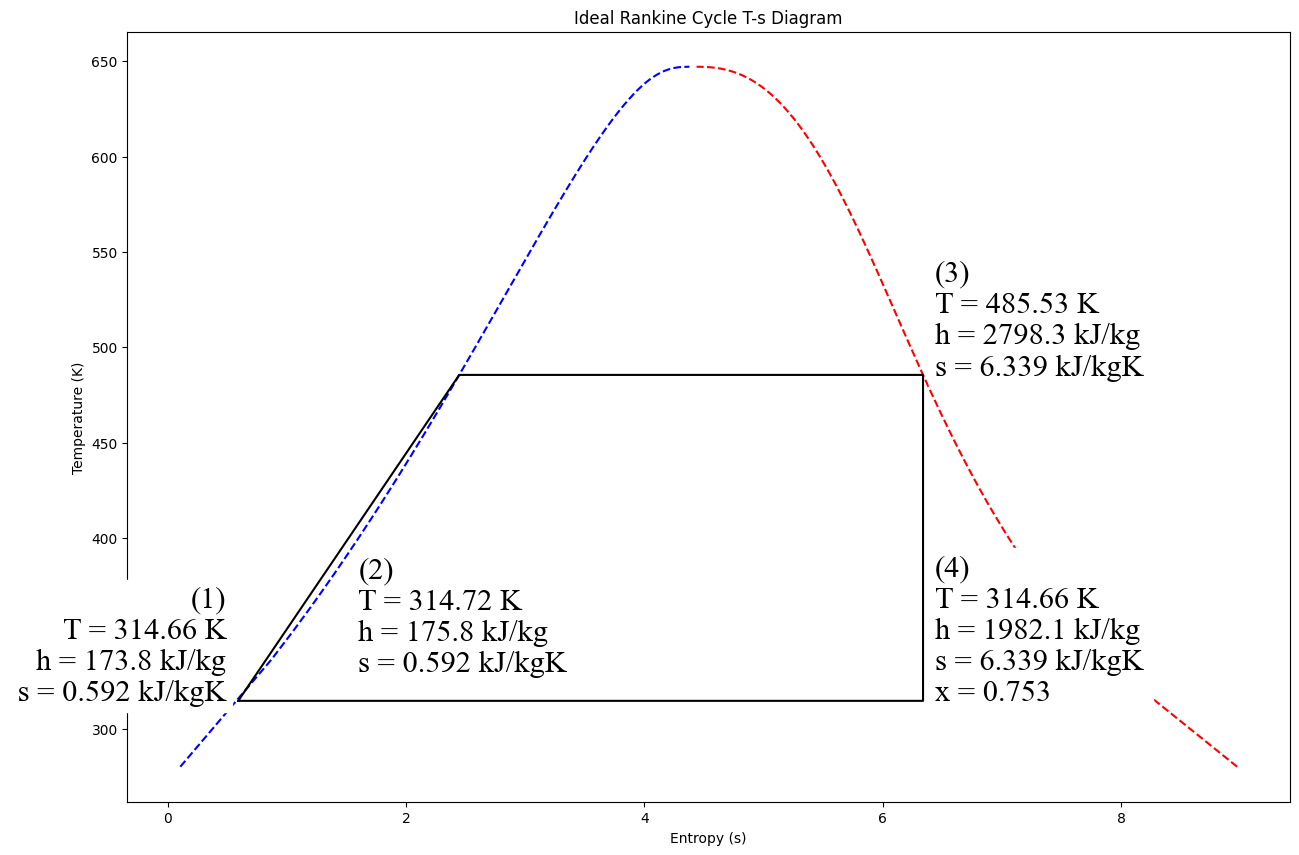

In [10]:
import numpy as np
import matplotlib.pyplot as plt

p = np.linspace(1,22063,1000)
T = mp_water.Ts(p=p)
s = mp_water.ss(p=p)


font = {'family' : 'Times New Roman',
        'size'   : 22}


plt.figure(figsize=(15,10))
plt.title('Ideal Rankine Cycle T-s Diagram')
plt.rc('font', **font)
plt.plot(s[0],T, 'b--')
plt.plot(s[1],T,'r--')
plt.ylabel('Temperature (K)')
plt.xlabel('Entropy (s)')
plt.plot([s1, s2, s3dash, s3, s4, s1],[T1, T2, T3dash, T3, T4, T1], 'black')

plt.text(s1-.1,T1,f'(1)\nT = {round(float(T1),2)} K\nh = {round(float(h1),1)} kJ/kg\n s = {round(float(s1),3)} kJ/kgK',
    ha='right',backgroundcolor='white')
plt.text(1.6,330,f'(2)\nT = {round(float(T2),2)} K\nh = {round(float(h2),1)} kJ/kg \ns = {round(float(s2),3)} kJ/kgK',
    ha='left',backgroundcolor='white')
plt.text(s3+.1,T3,f'(3)\nT = {round(float(T3),2)} K\nh = {round(float(h3),1)} kJ/kg \ns = {round(float(s3),3)} kJ/kgK',
    ha='left',backgroundcolor='white')
plt.text(s4+.1,T4,f'(4)\nT = {round(float(T4),2)} K\nh = {round(float(h4),1)} kJ/kg \ns = {round(float(s4),3)} kJ/kgK\nx = {round(float(x),3)}',
    ha='left',backgroundcolor='white')